# Student Evaluation Data Visualization
### _Diverging Stacked Bar Charts for Rose-Hulman Course Evaluation Data_
Author: Anna Scott

**Chart Design References:**
* Heiberger, Richard M., and Naomi B. Robbins. "Design of diverging stacked bar charts for Likert scales and other applications." _Journal of Statistical Software_ 57.5 (2014): 1-32.
* Robbins, Naomi B., and Richard M. Heiberger. "Plotting Likert and other rating scales." _Proceedings of the 2011 Joint Statistical Meeting._ 2011.

**Special thanks to:**
* Professor Richard Layton for his previous data visualization research
* [Stephanie Evergreen](http://stephanieevergreen.com/diverging-stacked-bars/ "How to Make a Diverging Stacked Bar Chart in Excel") for her transparent buffer method

**Instructions:**  
This notebook can be run and modified on its own, apart from the main dashboard notebook. However, Course_Evaluation_Data_Dashboard.ipynb and nbrun.py use this notebook for analysis, so **_please be cautious_** when modifying code other than the INSTRUCTOR DATA INPUT cell.

To use this notebook on its own, modify the INSTRUCTOR DATA INPUT cell to reference your .csv data file and change the aggregation options as necessary. Then go to **Cell --> Run All** to obtain your data visualization at the end of the notebook.

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib
matplotlib.style.use('seaborn-poster')
import numpy as np

In [2]:
# INSTRUCTOR DATA INPUT
data = pd.DataFrame.from_csv('Shibberu_CourseEvalData_Raw_20160616.csv',index_col=None)
course = None # must be a String or None
year = None # must be a String or None

In [3]:
data = data[['SURVEY_NAME','COURSE','QUESTION_NO','RESPONSE_1_COUNT','RESPONSE_2_COUNT','RESPONSE_3_COUNT',
             'RESPONSE_4_COUNT','RESPONSE_5_COUNT']] # only taking the needed columns

data = data[data.QUESTION_NO < 4] # removing non-typical survey questions

data.columns = ['SURVEY_NAME','COURSE','QUESTION_NO','R1','R2','R3','R4','R5'] # shortening data headers

In [4]:
if course is not None:
    data = data[data.COURSE.str.startswith(course)]
if year is not None:
    data = data[data.SURVEY_NAME.str.contains('_' + year)]

In [5]:
# question description dictionary
questions = {'1.04':'Quality of learning',
             '2.03':'Lab and course reinforce',
             '2.06':'Lighter Workload',
             '2.07':'Course overall',
             '3.02':'Professor well-prepared',
             '3.04':'Helpful teaching methods',
             '3.07':'Professor availability',
             '3.09':"Professor's interest in topic",
             '3.1':'Professor overall'}

In [6]:
# total response counts/question
lickert_counts = data.drop(['SURVEY_NAME','COURSE'],1).groupby('QUESTION_NO').sum()

# total responses per question (used for percentages chart)
lickert_counts['TOTAL'] = lickert_counts.sum(axis=1)
lickert_counts = lickert_counts.reset_index()

In [7]:
# creating percentage data from raw count totals
lickert_percents = pd.DataFrame()
lickert_percents['QUESTION_NO'] = lickert_counts.QUESTION_NO
lickert_percents['R5%'] = lickert_counts.R5 / lickert_counts.TOTAL * 100
lickert_percents['R4%'] = lickert_counts.R4 / lickert_counts.TOTAL * 100
lickert_percents['R3%'] = lickert_counts.R3 / lickert_counts.TOTAL * 100
lickert_percents['R2%'] = lickert_counts.R2 / lickert_counts.TOTAL * 100
lickert_percents['R1%'] = lickert_counts.R1 / lickert_counts.TOTAL * 100
# lickert_percents.sum(axis=1) # optional sanity check; should all be 100

In [8]:
# creating column of buffer values to offset bars
sums = lickert_percents['R5%'] + lickert_percents['R4%'] + 0.5 * lickert_percents['R3%']
maximum = sums.max()
buffer = maximum - sums
lickert_percents.insert(1,'BUFFER',buffer)

In [9]:
# sorting bars by 'agree' percentage and adding Lickert response headers
lp = lickert_percents.copy()#sort_values(by='BUFFER')
lp.columns = ['QUESTION_NO', 'BUFFER', 'Strongly Disagree', 'Disagree',
              'Neutral', 'Agree', 'Strongly Agree']

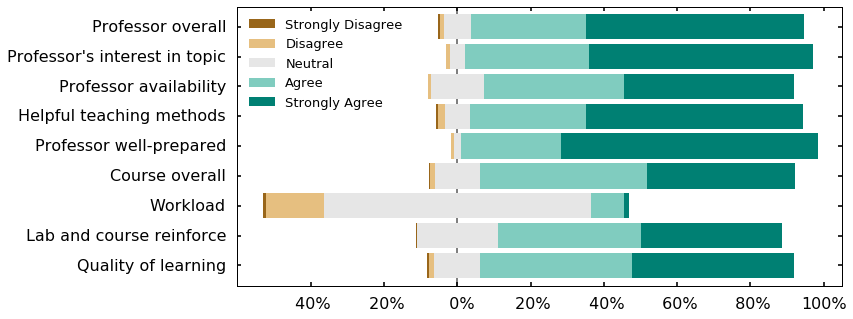

In [17]:
# custom colormap for buffer and diverging colors
cm = matplotlib.colors.ListedColormap([[1, 1, 1, 0], # transparent buffer
                                [0.6, 0.4, 0.1], [0.9, 0.75, 0.5], '0.85',
                                [0.5, 0.8, 0.75], [0, 0.5, 0.45]])

# creating initial stacked bar chart using custom colormap
p = lp.plot.barh(x='QUESTION_NO',stacked=True,colormap=cm,
                 edgecolor='none',figsize=(10.84,5),width=0.85)

# remove BUFFER from legend
lines, labels = p.get_legend_handles_labels()
p.legend(lines[1:], labels[1:], loc='upper left', fontsize=13, frameon=False)

# set x-axis tick locations and values
xvals = []
for x in range(-2,6):
    xvals.append(maximum+(x*20))

p.set_xticks(xvals)
p.set_xlim(xvals[0]-20, xvals[len(xvals)-1]+5) # uniform x-axis range
p.set_xticklabels(['{:3.0f}%'.format(np.absolute(x-maximum)) for x in xvals])

# set y-axis values and new line location
yvals = p.get_yticklabels()
p.set_yticklabels(['{}'.format(questions.get(y.get_text())) for y in yvals])
p.set_ylabel('',fontsize=0) # get rid of y-axis label
p.axvline(maximum, color='0.5', linewidth=2).set_zorder(0)